In [1]:
import sys
sys.path.append("/home/tsuchida/KLab_MultiModalModel/tsuchida_workdir/..")

from PIL import Image
import torch
from models.model_decode_freeze_out import MyModel

/opt/conda/envs/kmmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-small",
    transformer_model_name="google/flan-t5-base",
    ffn=True,
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    image_vocab_size=16384,
    loc_vocab_size=1600,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=256,
    max_target_length=256,
    # Train setting
    pretrain="train", 
    # Dir setting
    root_dir="/data01/",
    result_dir="results/",
    loss = "CrossEntropy",
)



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
model = MyModel(args).to(device)
# print(model)
# 読み込みたい重みのパスを指定
# path = "/home/tsuchida/KLab_MultiModalModel/results/pretrain_claa/imagenet/enc2_dec1/best.pth"
# path = "/home/tsuchida/KLab_MultiModalModel/tsuchida_workdir/freeze.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/a100/lr1e-5/cc3m/enc2_dec12/epoch_50.pth"
model.load(result_name=path)
print(model)
model.eval()

T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "max_length": 256,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 2,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
    

MyModel(
  (language_model): T5EncoderModel(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=1024, bias=False)
                (wi_1): Linear(in_featur

In [6]:
from transformers import AutoTokenizer
from torchvision import transforms
# src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256)
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True)

tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<loc_{i}>" for i in range(args.loc_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [7]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [8]:
def show_result(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        tgt_text = src_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        display(custom_to_pil(src_image[0]))
        output = model(src_image, src_text, tgt_text, return_loss=False)
        preds = src_tokenizer.batch_decode(output[:,1:-1])
        print('pred:', preds[0])

In [12]:
def show_data(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        display(custom_to_pil(src_image[0]))

### OpenImageDataset

In [ ]:
import os
from copy import deepcopy

import pandas as pd
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from ..dataset_loader import DatasetLoader

#存在しない画像を除外するためのリスト
dropimageidlist = ["7f1934f5884fad79","429019e83c1c2c94","4f818c006da84c9e","5b86e93f8654118a","673d74b7d39741c3","6dcd3ce37a17f2be","805baf9650a12710"
                   ,"98ac2996fc46b56d","a46a248a39f2d97c"]

class OpenImageDataset(DatasetLoader):
    """openimageのdetectionデータセット
    """    
    def __init__(self,data_dir:str="/data/dataset/openimage/",phase:str="train"):
        super().__init__()        
        if phase=="val":
            phase = "validation"

        with open(os.path.join(data_dir,f"{phase}_detection_40.csv")) as f:
            items = f.read()

        items = items.split("\n")
        items = [item.split(",") for item in items]
        num = int(len(items)/2)
        # データセット半分のみ使用
        items = items[1:10]
        # items = items[1:-1]
        self.tgt_texts = [item[1] for item in items]
        self.src_texts = ["What objects are in the image?"]*len(items)
        self.images = [os.path.join(data_dir,f"{phase}_256_png",f"{item[0]}.png") for item in items]

        #dropimageidlistに含まれる画像と対応するテキストを除外する
        for drop_id in dropimageidlist:
            drop_path = os.path.join(data_dir,f"{phase}_256_png",f"{drop_id}.png")
            if drop_path in self.images:
                drop_index = self.images.index(drop_path)
                self.tgt_texts.pop(drop_index)
                self.src_texts.pop(drop_index)
                self.images.pop(drop_index)

In [ ]:
train_dataset = OpenImageDataset(data_dir= args.root_dir + "openimage", phase="train")
val_dataset = OpenImageDataset(data_dir= args.root_dir + "openimage", phase="val")

##### CC3M（キャプション生成）

In [9]:
import os
# from .pretrain import PretrainDatasetLoader
import torch
from torchvision import transforms
from PIL import Image

class DatasetLoader(torch.utils.data.Dataset):
    def __init__(self, resize=256):
        self.images, self.tgt_texts, self.src_texts = [], [], []
        self.src_transforms = transforms.Compose([
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
        ])
        self.tgt_transforms = transforms.Compose([
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
        ])

    def __getitem__(self, idx):
        image, src_text, tgt_text = self.images[idx], self.src_texts[idx], self.tgt_texts[idx]
        image = Image.open(image).convert('RGB')
        src_image = self.src_transforms(image)
        tgt_image = self.src_transforms(image)

        return src_image, tgt_image, src_text, tgt_text
    
    def __len__(self):
        return len(self.images)


class CC3MDatasetLoader(DatasetLoader):
    def __init__(self, data_dir='/data/datatset/cc3m', phase='train'):
        super().__init__()
        if phase == 'train':
            tsv_path = os.path.join(data_dir, 'train.tsv')
        elif phase == 'val':
            tsv_path = os.path.join(data_dir, 'val.tsv')
        else:
            raise ValueError(f'Invalid phase: {phase}')

        with open(tsv_path, 'r') as f:
            lines = f.readlines()

        for line in lines[1:40]:
            img_name, caption = line.removesuffix('\n').split('\t')
            img_path = os.path.join(data_dir, phase, img_name)
            # print(img_path)
            if os.path.exists(img_path):
                self.images.append(img_path)
                self.src_texts.append('What does the image describe ?')
                self.tgt_texts.append(caption)

In [10]:
train_dataset = CC3MDatasetLoader(data_dir= args.root_dir + "cc3m", phase="train")
val_dataset = CC3MDatasetLoader(data_dir= args.root_dir + "cc3m", phase="val")
# train_dataset = get_dataset(args, dataset_name='cc3m', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
# val_dataset = get_dataset(args, dataset_name='cc3m', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

src_text: What does the image describe ?
tgt_text: old cars by building function


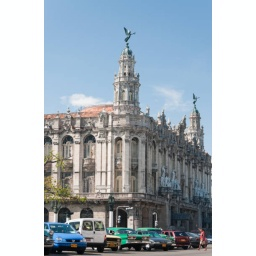

pred: the building is a city.

src_text: What does the image describe ?
tgt_text: sick business woman with flu blowing nose in tissue .


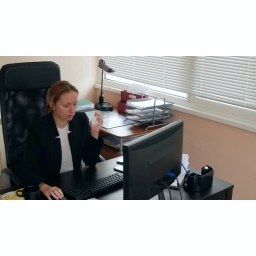

pred: businessman working on the office

src_text: What does the image describe ?
tgt_text: view from the shore of a fjord during summer


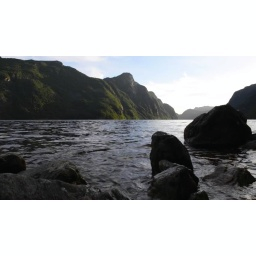

pred: a beautiful rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky rocky 

src_text: What does the image describe ?
tgt_text: author : a life in photography -- in pictures


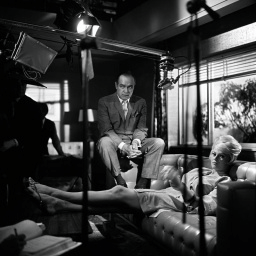

pred: actor and actor, actor, a man, a man, a man, a man, a man, a man, a tv, and actor, a man and actor, a man, a man, a man, a tv, and actor, a man and actor, a man, a man, a tv, and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and actor, a man and

src_text: What does the image describe ?
tgt_text: sandcastle beach on bright sky .


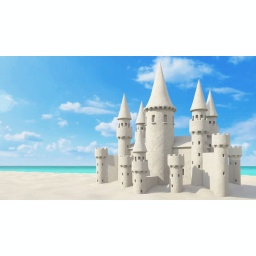

pred: the beach is a sand.

src_text: What does the image describe ?
tgt_text: political map with the several counties wherea city is highlighted .


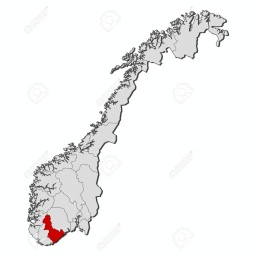

pred: a map of the ice.



In [11]:
show_result(train_dataset, idx=0)
print()
show_result(train_dataset, idx=1)
print()
show_result(train_dataset, idx=2)
print()

show_result(val_dataset, idx=0)
print()
show_result(val_dataset, idx=1)
print()
show_result(val_dataset, idx=2)
print()

# ImageNet

In [8]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='imagenet', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='imagenet', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

src_text: What does the image describe ?
tgt_text: kit fox


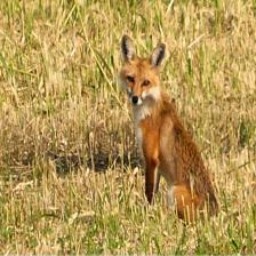

pred: ruddy turnstone

src_text: What does the image describe ?
tgt_text: badger


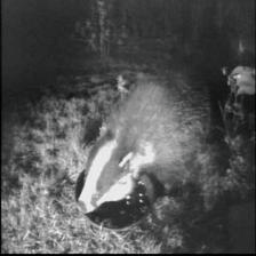

pred: fig

src_text: What does the image describe ?
tgt_text: gondola


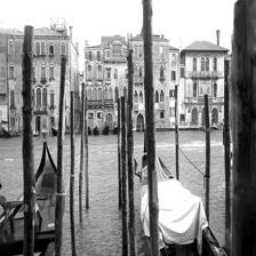

pred: sulphur butterfly

src_text: What does the image describe ?
tgt_text: zebra


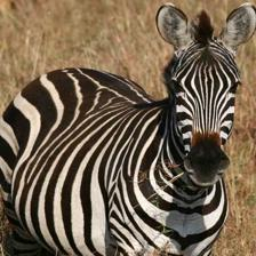

pred: ruddy turnstone


In [14]:
show_result(train_dataset, idx=10)
print()
show_result(train_dataset, idx=20000)
print()
show_result(train_dataset, idx=300000)
print()
show_result(train_dataset, idx=100000)

src_text: What does the image describe ?
tgt_text: Siberian husky


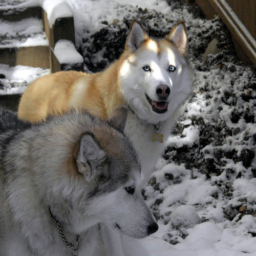

pred: papillon

src_text: What does the image describe ?
tgt_text: black grouse


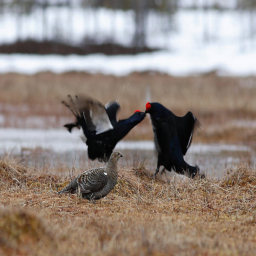

pred: buckeye

src_text: What does the image describe ?
tgt_text: trilobite


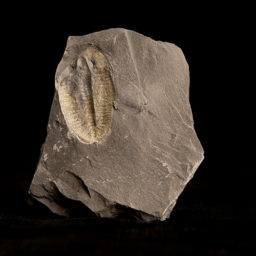

pred: syringe

src_text: What does the image describe ?
tgt_text: Christmas stocking


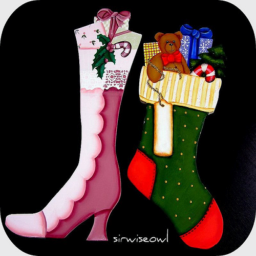

pred: slug


In [13]:
show_result(val_dataset, idx=100)
print()
show_result(val_dataset, idx=20000)
print()
show_result(val_dataset, idx=30000)
print()
show_result(val_dataset, idx=40000)

# SUN397

src_text: A short image description<extra_id_0> locker room.
tgt_text: <extra_id_0>:<extra_id_1>


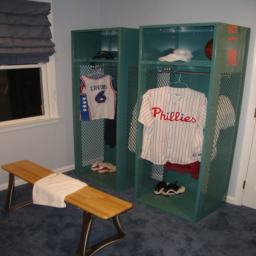

pred: <extra_id_0>.


In [111]:
from data import get_dataset

dataset = get_dataset(args, dataset_name='sun397', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))
show_result(train_dataset, idx=10)

# Places365

src_text: A short<extra_id_0> description: airfield.
tgt_text: <extra_id_0> image<extra_id_1>


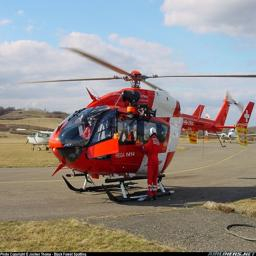

pred: <extra_id_0>.<extra_id_1> a<extra_id_3> a<extra_id_4> a<extra_id_4> a<extra_id_4> a<extra_id_4> a<extra_id_4>


In [112]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='places365', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
# val_dataset = get_dataset(args, dataset_name='places365', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
show_result(train_dataset, idx=10)

# iNaturalist

src_text: An image that shows Animali<extra_id_0> Annelida Clitellata Ha<extra_id_1>taxida<extra_id_2>bricidae Lumbricu<extra_id_3> terres<extra_id_4>s.
tgt_text: <extra_id_0>a<extra_id_1>plo<extra_id_2> Lum<extra_id_3>s<extra_id_4>tri<extra_id_5>


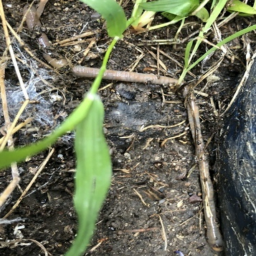

pred: <extra_id_0> a<extra_id_1>


In [113]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='inaturalist', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
# val_dataset = get_dataset(args, dataset_name='inaturalist', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
show_result(train_dataset, idx=10)

# RedCaps

In [116]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="redcaps", src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))

src_text: Churchill is ready<extra_id_0> the holidays!
tgt_text: <extra_id_0> for<extra_id_1>


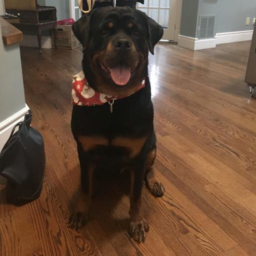

pred: <extra_id_0> a<extra_id_1>


In [117]:
show_result(train_dataset, idx=10)

# CC3M

In [19]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='cc3m', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

src_text: <extra_id_0>s : till all are issue # 4b
tgt_text: transformer<extra_id_1>


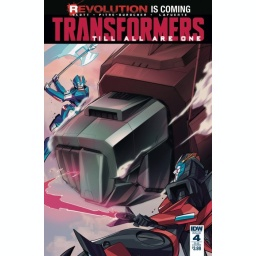

pred: <extra_id_0> t<extra_id_1>


In [24]:
show_result(train_dataset, idx=200)

# CC12M

src_text: Si<extra_id_0>rian Hu<extra_id_1> into the wild. Amazing portrait of a<extra_id_2>berian Husky wolf dog into the<extra_id_3> of the forest on fresh powder snow ground stock<extra_id_4>
tgt_text: <extra_id_0>be<extra_id_1>sky<extra_id_2> Si<extra_id_3> wild<extra_id_4> images


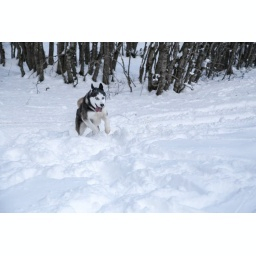

pred: <extra_id_0> a<extra_id_2>


In [120]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="cc12m", src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))
show_result(train_dataset, idx=10)

# 分割テスト

In [ ]:
import random

mask_tokens: list

def generate_target_ids(input_id, mask_prob):
    """This function takes a list of sentences and generates the pair (input_ids, target_ids) for pretraining the
    model. It implements in a simple way the final T5 denoising objective, as per HuggingFace documentation.

    :param mask_prob: Probability of masking a token.
    :param input_ids: A list of sublists, where the sublists are sequences of input ids (tokenized sentences). This
        mutable sublists are modified within this function, masking the tokens that the model has to denoise for
        pretraining.
    :return: The correspondent target sequences of ids for each input sentence, with the unmasked tokens.
    """
    target_id = []
    masked_indexes = sorted(random.sample(range(0, len(input_id)),  # sample a word index in sentence
                                            min(int(mask_prob * len(input_id)),  # number of tokens masked
                                                len(mask_tokens) - 1)))  # but never more than special tokens available
    mask = [(i in masked_indexes)  # this is True or False
            for i in range(len(input_id))]
    i = 0
    end = len(input_id)
    masked_spans_counter = 0
    while i < end:
        if mask[i]:
            current_words_masked = [input_id[i]]
            input_id[i] = mask_tokens[masked_spans_counter]
            masked_spans_counter += 1
            while i + 1 < end and mask[i + 1]:
                current_words_masked.append(input_id[i + 1])
                del input_id[i + 1]
                del mask[i + 1]
                end -= 1
            target_id.extend(current_words_masked)
        else:
            if len(target_id) == 0 or target_id[-1] != mask_tokens[masked_spans_counter]:
                target_id.append(mask_tokens[masked_spans_counter])
        i += 1
    return target_id

In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-base")
mask_tokens = tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'Thank you for inviting me to your party last week. I had a wonderful time.'
sequence = tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)[
    "input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
sequence = torch.tensor(sequence)
sequence = torch.nn.functional.pad(sequence, (0, 512 - len(sequence)), 'constant', 0)
print(sequence.shape)
target_id = torch.tensor(target_id)
target_id = torch.nn.functional.pad(target_id, (0, 512 - len(target_id)), 'constant', 0)
print(target_id.shape)
print(tokenizer.decode(sequence))
print(tokenizer.decode(target_id))

In [ ]:
mask_tokens = src_tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'a photo of dog.'
sequence = tgt_tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)["input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
print(sequence)
print(tgt_tokenizer.decode(sequence))
print(target_id)
print(tgt_tokenizer.decode(target_id))

In [ ]:
src_tokenizer.pad_token_id